algo_factory (generic function with 1 method)

### All-best

In [180]:
"""
trying to run bandits and see the performance of the estimator.

"""

using Infiltrator
using ProgressMeter
using Plots
plotly()

include("./KjBandits.jl")
include("./KjFunctions.jl")


opt = (
    σ² = (1.0/2)^2, 
    dataseed = 313, #123
    algoseed = 789,
    n_trials = 200, #50, #1000, #200
    N_ary = [10, 20, 40, 100, 1000, 2000, 4000, 6000, 8000, 10000], 
    K = 64, # 3:8, 3:10
    algo_name = "uniform", # "ucb", # "ucb", "sr", "uniform"
    problem_name = "poly_K", #"equal", "allbest", #"linear_K20" #"linear", "linear_K2_custom", "linear_K2"
    
    splits = nothing,
    Delta = 1.0/(64^3),
)
#estimator_names = ["haver", "naiveoracle", "avg", "max", "weighted_100", "weightedms_4", ]
estimator_names = ["naiveoracle", "haver", "avg", "max", "weightedms_4", "double"]
@show estimator_names
@show opt

hatvalues = zeros(opt.n_trials, length(opt.N_ary), length(estimator_names))
global estimators
global i_t_ary
rng_data = MersenneTwister(opt.dataseed)
rng_algo = MersenneTwister(opt.algoseed) 
rng_algo2 = MersenneTwister(opt.algoseed*31 + 1)
algo = []
problem = []
@showprogress for i_try = 1:opt.n_trials
#    global algo, problem
    myseed = rand(rng_data, UInt32)

    for i_N in eachindex(opt.N_ary)
        global problem, algo
        N = opt.N_ary[i_N]

        problem = problem_factory(
            opt.problem_name, opt.σ²,  myseed, 
            K=opt.K, num_optimals=opt.num_optimals, 
            degree=opt.degree, Delta=opt.Delta, gap_splits=opt.gap_splits)

        algo = algo_factory(opt.algo_name, problem, rand(rng_algo, UInt32))

        myseed2 = rand(rng_algo2, UInt32)
        estimators = [ estimator_factory(name, opt.σ², problem.μ, myseed2) for name in estimator_names]
    
        data = zeros(opt.K, N)
        for i in 1:opt.K
            algo.n_pulls[i] = N
            rewards = problem.μ[i] .+ sqrt(problem.σ²)*randn(problem.rngs[i], N) 
            algo.sum_rewards[i] = sum(rewards) 
            data[i,:] .= rewards
        end 
        
        for i_est in 1:length(estimators)-1
            hatvalues[i_try, i_N, i_est] = estimate_value(estimators[i_est], algo)
        end
        hatvalues[i_try, i_N, end] = estimate_value(estimators[end], data)
        
        @assert maximum(problem.μ) == 0.0
    end
    #- compute the bias and the MSE
end
bias = meansqueeze(hatvalues, 1) # n_alphas x n_estimators
mse = meansqueeze(hatvalues .^ 2, 1)
mae = meansqueeze(abs.(hatvalues), 1)

x = opt.N_ary
i = 1; plot(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 2; plot!(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3)
# i = 3; plot!(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3) 
i = 4; plot!(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 5; plot!(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 6; plot!(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3)
plot!(xlabel="N", ylabel="log(MSE)", legend=:outertopright)  
title!("mse")

estimator_names = ["naiveoracle", "haver", "avg", "max", "weightedms_4"]
opt = (σ² = 0.25, dataseed = 313, algoseed = 789, n_trials = 200, N_ary = [10, 20, 40, 100, 1000, 2000, 4000, 6000, 8000, 10000], K = 64, algo_name = "uniform", problem_name = "poly_K", splits = nothing, Delta = 3.814697265625e-6)
0.0:0.015625:0.984375
[0.0, -0.015625, -0.03125, -0.046875, -0.0625, -0.078125, -0.09375, -0.109375, -0.125, -0.140625, -0.15625, -0.171875, -0.1875, -0.203125, -0.21875, -0.234375, -0.25, -0.265625, -0.28125, -0.296875, -0.3125, -0.328125, -0.34375, -0.359375, -0.375, -0.390625, -0.40625, -0.421875, -0.4375, -0.453125, -0.46875, -0.484375, -0.5, -0.515625, -0.53125, -0.546875, -0.5625, -0.578125, -0.59375, -0.609375, -0.625, -0.640625, -0.65625, -0.671875, -0.6875, -0.703125, -0.71875, -0.734375, -0.75, -0.765625, -0.78125, -0.796875, -0.8125, -0.828125, -0.84375, -0.859375, -0.875, -0.890625, -0.90625, -0.921875, -0.9375, -0.953125, -0.96875, -0.984375]


LoadError: UndefVarError: `stop` not defined

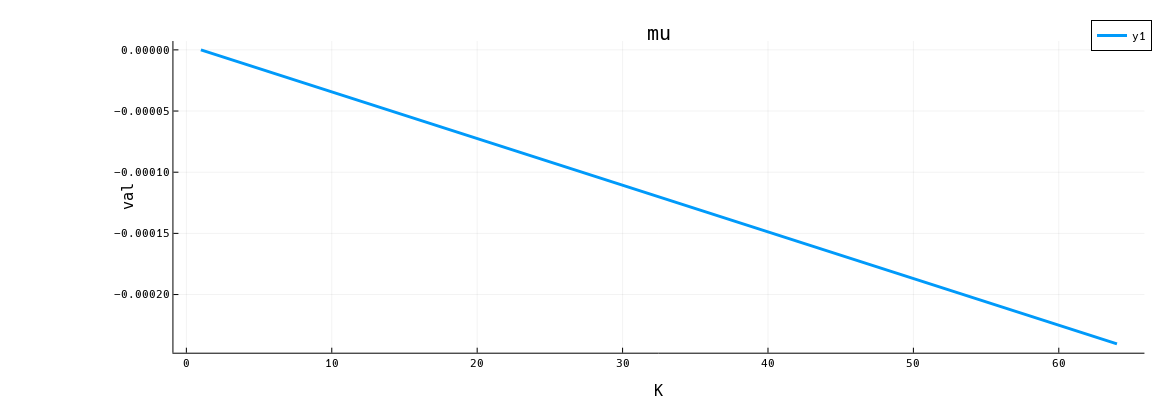

In [178]:
x = 1:opt.K
plot(x, problem.μ, linewidth=3)
plot!(xlabel="K", ylabel="val")  
title!("mu")

In [159]:
x = opt.N_ary

i = 1; plot(x, bias[:,i], label=estimator_names[i], linewidth=3)
i = 2; plot!(x, bias[:,i], label=estimator_names[i], linewidth=3)
# i = 3; plot!(x, bias[:,i], label=estimator_names[i], linewidth=3)
i = 4; plot!(x, bias[:,i], label=estimator_names[i], linewidth=3)
i = 5; plot!(x, bias[:,i], label=estimator_names[i], linewidth=3)
# i = 6; plot!(x, bias[:,i], label=estimator_names[i], linewidth=3)
plot!(xlabel="N", ylabel="bias", legend=:outertopright)  
title!("bias")

LoadError: MethodError: no method matching problem_factory(::String, ::Float64, ::Int64; K::Int64, alpha::Float64, Delta::Nothing, splits::Nothing)

[0mClosest candidates are:
[0m  problem_factory(::String, ::Real)[91m got unsupported keyword arguments "K", "alpha", "Delta", "splits"[39m
[0m[90m   @[39m [35mMain[39m [90m/data/tnn/10_School/02_ResearchProjects/01_MCTS_Analysis/01_mcts_codes/[39m[90m[4mKjFunctions.jl:1[24m[39m
[0m  problem_factory(::String, ::Real, [91m::UInt32[39m; K, alpha, Delta, splits)
[0m[90m   @[39m [35mMain[39m [90m/data/tnn/10_School/02_ResearchProjects/01_MCTS_Analysis/01_mcts_codes/[39m[90m[4mKjFunctions.jl:1[24m[39m
